## Correcting for autocorrelation in regression analyses of neuronal data.

**Thomas Akam 2020**

This notebook explores ways of computing P values in regression analyses of neuronal data which correct for the effect of autocorrelation in behavioural and neuronal time series.  Such autocorrealtions severely overinflate the number of neurons identified as significantly related to behaviour if P values from a standard regression analysis are used, see [Elber-Dorozko & Loewenstein 2018](https://elifesciences.org/articles/34248).

We first generate some simualated behavioural and neuronal activity time series.  Time series with and without autocorrelation are generated.  The uncorrelated time series are are Gaussian white noise. The autocorrelated time series are Guassian white noise filtered with a Gaussian kernel.

Text(0.5, 0, 'Trial number')

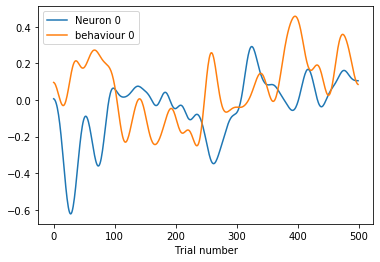

In [21]:
import numpy as np
import pylab as plt
from scipy.ndimage import gaussian_filter1d

n_neurons = 100
n_behaviour = 100
n_trials = 500
smooth_SD = 10

def generate_signals(n_signals, n_trials, smooth_SD):
    # Generate autocorrelated signals by gaussian smoothing white noise.
    x = np.random.randn(n_signals, n_trials)
    if smooth_SD:
        x = gaussian_filter1d(x, smooth_SD, axis=1)
    return x

# Generate signals without autocorrelation.

a_unc = generate_signals(n_neurons  , n_trials, False) # Neuronal activity
b_unc = generate_signals(n_behaviour, n_trials, False) # Behavioural variables

# Generate signals with autocorrelation.

a_cor = generate_signals(n_neurons  , n_trials, smooth_SD) # Neuronal activity
b_cor = generate_signals(n_behaviour, n_trials, smooth_SD) # Behavioural variables

# Plot example autocorrelated signals.

plt.plot(a_cor[0,:], label='Neuron 0')
plt.plot(b_cor[0,:], label='behaviour 0')
plt.legend()
plt.xlabel('Trial number')

First we will run a set of standard linear regressions each predicting a single neuronal time series from a single behaviuoral time series.  We will plot the sorted P values along with the predicted sorted P values given there is no relationship between the signals.

In [22]:
from tqdm import tqdm
from scipy.stats import linregress

def linregress_p_value(x,y):
    # Return the P values for a linear regression predicting y using x.
    return linregress(x, y).pvalue

def sorted_P_values(A, B, p_val_func):
    # Calculate P values for each regression predicting a neuronal activity signal A[i,:]
    # using a behavioural signal B[j,:]. P values are computed using the provided p_val_func.
    n_neurons = A.shape[0]
    n_behaviour = B.shape[0]
    p_values = np.zeros([n_neurons, n_behaviour])                        
    for i in tqdm(range(n_neurons)):
        for j in range(n_behaviour):
            p_values[i,j] = p_val_func(B[j,:], A[i,:])
    return np.sort(p_values, axis=None)

def PP_plot(sorted_values):
    n = len(sorted_values)
    x = np.arange(1, n+1)/n
    plt.loglog([x[0],1],[x[0],1], 'k', label='Uniform')
    plt.loglog(x, sorted_values, 'b', label='Empirical')
    plt.xlabel('Quantile')
    plt.ylabel('P value')
    plt.legend()
    plt.xlim([0.001,1])

For the uncorrelated data, P values returned by a standard regression analysis are distributed uniformly between 0 and 1, as expected given the absence of any predictive relationhsip between the time series.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.66it/s]


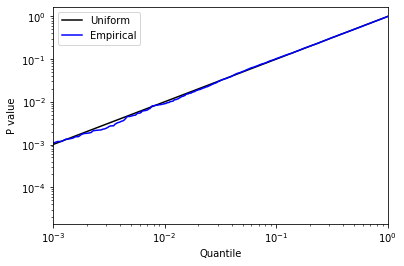

In [3]:
P_values_unc = sorted_P_values(a_unc, b_unc, linregress_p_value)
PP_plot(P_values_unc)

Now let's try on the autocorrelated data...

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.45it/s]


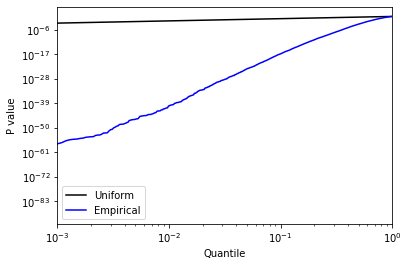

In [4]:
P_values_cor = sorted_P_values(a_cor, b_cor, linregress_p_value)
PP_plot(P_values_cor)

Yikes!  Due to autocorrelation in the signals, naively using the P values obtained from a standard regression analysis suggest that overwhelmingly significant preditive relationships exist between almost all behaviour and neuronal time series despite the lack of any actual relationship. 

### Circular shift permutation test

Now lets calculate P values using a permutation test which preserves the autocorrelation in both time series but randomises the relationship between them using circular shifts of behaviour relative to neuronal activity.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


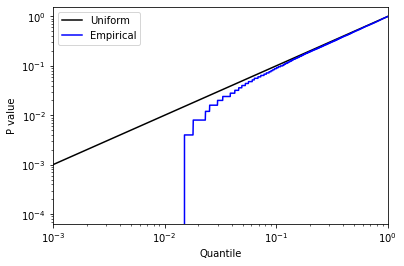

In [5]:
from sklearn.linear_model import LinearRegression

ols = LinearRegression()

def circ_shift_P_value(x, y):
    # Calculate the P value for a linear regression predicting y using x by comparing
    # the beta weight for the real data with the distribution of beta weights over an
    # ensemble of datasets obtained by circularly shifing one of the time series.
    # This function computes the distribution using all possible circular shifts.
    ols.fit(x.reshape(-1, 1),y.reshape(-1, 1))
    true_beta = ols.coef_[0,0]
    circ_shift_y = np.vstack([np.roll(y,s) for s in range(len(y))])
    ols.fit(x.reshape(-1, 1),circ_shift_y.T)
    perm_betas = ols.coef_
    p_value = 2*np.min([np.mean(perm_betas>true_beta), np.mean(perm_betas<true_beta)]) 
    return p_value

circ_shift_P_values = sorted_P_values(a_cor, b_cor, circ_shift_P_value)
        
PP_plot(circ_shift_P_values)
    

The distribution looks much better than that obtained by naively using the P values returned by a standard regression analysis. The P values change in discrete steps because the maximum number of different permutations that can be done for a given neuron-behaviour pair is limited by the number of trials (500 here).  As 10000 neuron-behaviour pairs contributed to the plot, the total number of permutations is large enough that the results are effectively deterministic when the analysis is re-run.

However, this permuation test does still inflate the number of small P values, probably due to the discontinuity between the start and end of the session which means that the distribution of the permuted data does not exactly match that the true data is drawn from.


### Fourier phase randomisation permutation test

Now lets try an alternative approach to generated permuted datasets where we randomise the phase of each Fourier coefficient of one of the signals.  First we will show what phase randomisation does to one of our simulated time series.

Text(0.5, 1.0, 'Amplitude spectra')

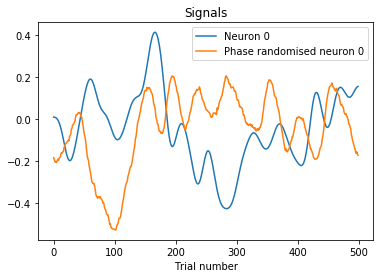

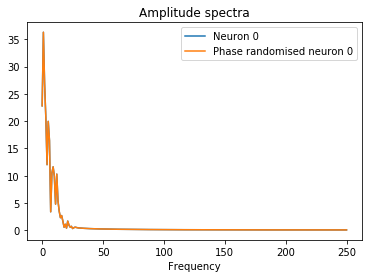

In [6]:
def randomise_phase(x):
    # Randomise the Fourier phases of 1D signal x while keeping the amplitudes constant.
    fft = np.fft.rfft(x)
    fft_amp = np.abs(fft)
    fft_ang = np.angle(fft)
    if len(x)%2 == 0:  # Even length, first and last fft elements are real valued.
        fft_ang[1:-1] = np.random.rand(len(fft)-2)*2*np.pi
    else: # Odd length, first fft element is real valued.
        fft_ang[1:] = np.random.rand(len(fft)-1)*2*np.pi
    prfft = fft_amp*np.cos(fft_ang)+1j*fft_amp*np.sin(fft_ang)
    return np.fft.irfft(prfft,len(x))

# Plot example signal and a phase randomised version of it. 

x = a_cor[0,:]
x_pr = randomise_phase(a_cor[0,:])

plt.plot(x, label='Neuron 0')
plt.plot(x_pr, label='Phase randomised neuron 0')
plt.xlabel('Trial number')
plt.legend()
plt.title('Signals')

plt.figure()
plt.plot(np.abs(np.fft.rfft(x)),label='Neuron 0')
plt.plot(np.abs(np.fft.rfft(x_pr)),label='Phase randomised neuron 0')
plt.xlabel('Frequency')
plt.legend()
plt.title('Amplitude spectra')

Now we compute P values using a permutation test using phase randomisation.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [56:11<00:00, 33.71s/it]


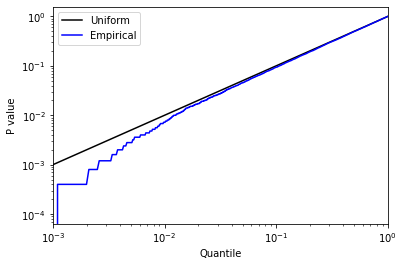

In [10]:
def phase_shift_P_value(x, y, n_perm=5000):
    # Calculate the P value for a linear regression predicting y using x by comparing the 
    # absolute value of the regression coefficient obtained on the real data with the
    # distribution of absolute values obtained by running the regression analysis on an 
    # ensemble of datasets obtained by randomising the fourier phase of one of the time series.
    ols.fit(x.reshape(-1, 1),y.reshape(-1, 1))
    true_beta = ols.coef_[0,0]
    phase_shift_y = np.vstack([randomise_phase(y) for _ in range(n_perm)])
    ols.fit(x.reshape(-1, 1), phase_shift_y.T)
    perm_betas = ols.coef_
    p_value = 2*np.min([np.mean(perm_betas>true_beta), np.mean(perm_betas<true_beta)]) 
    return p_value

phase_shift_P_values = sorted_P_values(a_cor, b_cor, phase_shift_P_value)
        
PP_plot(phase_shift_P_values)

Again, the distribution is much better than that obtained by naively using the P values returned by a standard regression analysis.  This permuation test also somewhat inflates the number of the smallest P values, but the effect is weaker than for the circular shift based permutation.  It is not clear to me why this happens using this permutation method, one possibility is that it results from edge effects, as the FFT treats the signal as if it is circular when it is discontinuous at the edges. 

Annother possibility is that if the phase relationships between frequencies are not random in the raw signals, e.g. due to the presence of harmonics, randomising Fourier phase may not be an appropriate permutation as it will break this correlation structure between frequences.  To test this lets create some signals where the phases at different frequencies are strongly non-independent due the the presence of sharp transitions between binary levels.

Text(0.5, 0, 'Trial number')

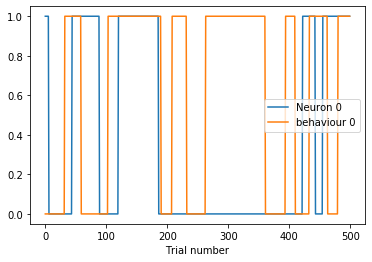

In [7]:
# Generate autocorrelated binary signals.

a_bin = (a_cor > 0).astype(float) # Neuronal activity
b_bin = (b_cor > 0).astype(float) # Behavioural variables

# Plot example signals.

plt.plot(a_bin[0,:], label='Neuron 0')
plt.plot(b_bin[0,:], label='behaviour 0')
plt.legend()
plt.xlabel('Trial number')

Unlike with the previous signals, randomising Fourier phases makes these signals look very different:

Text(0.5, 1.0, 'Signals')

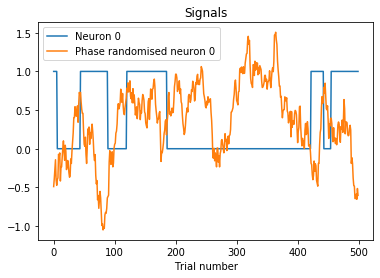

In [8]:
x = a_bin[0,:] # Example signal
x_pr = randomise_phase(x) # Phase randomised example signal.

plt.plot(x, label='Neuron 0')
plt.plot(x_pr, label='Phase randomised neuron 0')
plt.xlabel('Trial number')
plt.legend()
plt.title('Signals')


Does the Fourier phase randomisation permutation test still give sensible P values when applied to these binary signals?

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [56:54<00:00, 34.14s/it]


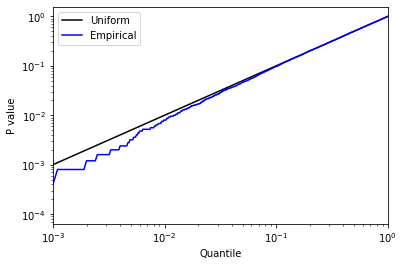

In [11]:
phase_shift_P_values_bin = sorted_P_values(a_bin, b_bin, phase_shift_P_value)
        
PP_plot(phase_shift_P_values_bin)

It turns out that the phase randomisation permutation works just as well with these signals as it did with the smooth ones.

### Regression with autoregressive model

Rather than using permutation based statistics, can we fix the problems using a regression model which explicitly models the autocorrelation?

First try a basic autoregressive model which inlcudes prior lags of y as predictors but does not model the residuals as autocorrelated.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.44it/s]


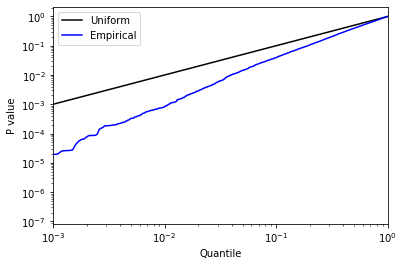

In [20]:
from statsmodels.tsa.ar_model import AutoReg

def AR_model_p_value(x,y):
    return AutoReg(y, lags=50, exog=x).fit().pvalues[-1]

AR_P_values = sorted_P_values(a_cor, b_cor, AR_model_p_value)
        
PP_plot(AR_P_values)


This model gives massively overinflated P values, presumably due to not modelling autocorrelation in the residuals.  The next step is try using an ARMA model which assumes autocorrelated residuals.

In [ ]:
from statsmodels.tsa.arima_model import ARMA

def ARMA_p_value(x,y):
    return ARMA(y, order=(1,1), exog=x).fit().pvalues[1]

ARMA_P_values = sorted_P_values(a_cor, b_cor, ARMA_p_value)
        
PP_plot(ARMA_P_values)

Attempting to fit this ARMA model is giving an error:
```
ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
```